In [1]:
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from qlib.data import D
from qlib.config import REG_CN
from qlib.contrib.data.handler import Alpha158
from qlib.data.filter import NameDFilter, ExpressionDFilter
from qlib.contrib.model.gbdt import LGBModel
from qlib.contrib.data.handler import Alpha158
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


In [2]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/day1_data_qlib', region=REG_CN)
expressionDFilter = ExpressionDFilter(rule_expression='$volume != 0')
instruments = D.instruments(market = 'all', filter_pipe=[expressionDFilter])
#instruments = D.instruments(market = 'all')

[18920:MainThread](2025-05-16 11:04:23,427) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[18920:MainThread](2025-05-16 11:04:23,433) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[18920:MainThread](2025-05-16 11:04:23,434) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/day1_data_qlib')}


In [10]:
new = D.features(instruments = instruments, fields = ['$new'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
ST = D.features(instruments = instruments, fields = ['$ST'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_close = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_open = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
# stock_list = D.list_instruments(instruments = instruments,
#                                 start_time='2022-01-01',
#                                 end_time='2025-03-31',
#                                 as_list=True)

In [3]:
trade_date = D.calendar(start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day')

In [4]:
# 剔除当天正股为ST股的可转债的因子值,factor为dict格式
def exclude_ST(factor):
    for date in factor.keys():
        factor[date] = factor[date][ST.loc[date] == 0]
    return factor

# 剔除当天为新债的可转债的因子值，factor为dict格式
def exclude_newbond(factor):
    for date in factor.keys():
        factor[date] = factor[date][new.loc[date] == 0]
    return factor

# 缩尾处理将超过分位数的因子替换为边界值,factor为dict格式，low为下分位数，up为上分位数
def winsorize(factor,low = 0.05, up = 0.95):
    for date in factor.keys():
        s = factor[date].copy()
        lower = s.quantile(low)
        upper = s.quantile(up)
        factor[date] = s.clip(lower, upper)
    return factor

# 标准化处理,factor为dict格式
def factor_std(factor):
    for date in factor.keys():
        factor[date] = (factor[date] - factor[date].mean()) / factor[date].std()
    return factor

In [5]:
# 将dataframe格式的因子数据表变为dict格式,
def factor_dict(factor):
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    return factor_dict

In [6]:
# 计算因子每日分组收益率,N为分组数,factor为dict格式
def cal_group_return(factor, N):
    date_list = list(factor.keys())
    group_return={}
    if cal_RankIC_mean(factor) > 0:
        for date in date_list[:-1]:
            stock_all = factor[date].index.tolist()
            factor[date].dropna(inplace = True)
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close.shift(-1)/data_close - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group'+str(N)] - stock_return['group1']
            stock_return['benchmark'] = (data_close.loc[:,stock_all].shift(-1)/data_close.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    else:
        for date in date_list[:-1]:
            stock_all = factor[date].index.tolist()
            factor[date].dropna(inplace = True)
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close.shift(-1)/data_close - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group1'] - stock_return['group'+str(N)]
            stock_return['benchmark'] = (data_close.loc[:,stock_all].shift(-1)/data_close.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    return group_return

In [7]:
# 画出分组累积超额收益走势，factor为dict格式，N为组数
def plot_return(factor, N):
    group_return = cal_group_return(factor, N)
    group_cum_return = pd.DataFrame(group_return).T
    for i in range(1,N+1):
        group_cum_return['group'+str(i)] = group_cum_return['group'+str(i)] - group_cum_return['benchmark']
    group_cum_return.dropna(how='all', inplace=True)
    group_cum_return = group_cum_return.shift(1)
    group_cum_return.iloc[0] = 0
    group_cum_return.index = group_cum_return.index.strftime('%Y-%m')
    group_cum_return.cumsum().iloc[:,:N+1].plot()

# 每日因子所包含的可转债数量,factor为dict格式
def cal_amount(factor):
    amount = {}
    for date in factor.keys():
        amount[date] = factor[date].dropna().count()
    return pd.Series(amount)
    
# 计算年化收益率，factor为dict格式，N为组数
def cal_annual_return(factor, N):
    return (pd.DataFrame(cal_group_return(factor, N)).T).mean() * 252

# 计算每日IC值，factor为dict格式
def cal_IC(factor):
   factor_df = pd.DataFrame(factor)
   return factor_df.corrwith((data_close.shift(-1)/data_close-1).T).dropna()

# 计算每日IC均值，factor为dict格式
def cal_IC_mean(factor):
    IC = cal_IC(factor).mean()
    return IC

# 计算每日RankIC值，factor为dict格式
def cal_RankIC(factor):
   factor = pd.DataFrame(factor)
   return factor.corrwith((data_close.shift(-1)/data_close-1).T, method = 'spearman')

# 计算每日RankIC均值，factor为dict格式
def cal_RankIC_mean(factor):
    RankIC = cal_RankIC(factor).mean()
    return RankIC

# 计算日度RankICIR值，factor为dict格式
def cal_RankICIR(factor):
    RankIC = cal_RankIC(factor)
    ICIR = RankIC.mean() / RankIC.std()
    return ICIR

# 计算日度胜率,factor为dict格式,N为组数
def cal_winrate(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T
    return (group_return > 0).sum() / len(group_return.index)

# 计算最大回撤，factor为dict格式，N为组数
def cal_MDD(factor, N):
    group_return = cal_group_return(factor, N)
    DD = (pd.DataFrame(group_return).T + 1).cumprod() - (pd.DataFrame(group_return).T + 1).cumprod().cummax()
    MDD = np.abs(DD).max()
    return MDD

# 计算分组累积超额收益,factor为dict格式,N为组数
def cal_alpha(factor, N):
    group_return = cal_group_return(factor, N)
    group_return = pd.DataFrame(group_return).T
    group_return_cumprod = (group_return + 1).cumprod()
    excess_Return = group_return_cumprod.sub(group_return_cumprod['benchmark'], axis = 0)
    return excess_Return.iloc[:,:-1]

# 计算多头年化超额,factor为dict格式，N为组数
def cal_long_return(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.mean() * 252
        return long
    
# 计算多头超额胜率,factor为dict格式，N为组数
def cal_long_winrate(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    
# 计算年化夏普比率,factor为dict格式，N为组数，rate为无风险利率
def cal_sharp(factor, N, rate=0.02):
    annual_return = cal_annual_return(factor, N) - rate
    std = pd.DataFrame(cal_group_return(factor, N)).T.std() * math.sqrt(252)
    sharp = annual_return / std 
    return sharp

# 计算概率，factor为dict格式，N为组数
def cal_probability(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T.iloc[:,:-1]
    group_return = group_return.rolling(20).sum().dropna(how = 'all')
    group_cols = [col for col in group_return.columns[:N]]
    if cal_RankIC_mean(factor) < 0:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[0]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] >= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    else:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[0]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] <= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    n = len(group_return.index)
    p0, p1, p2, p3 = group_return['概率0'].sum()/n, group_return['概率1'].sum()/n, group_return['概率2'].sum()/n, group_return['概率3'].sum()/n
    return pd.Series([p0,p1,p2,p3],index = ['概率0','概率1','概率2','概率3'])
    

In [8]:
# 分池，factor为dataframe格式
def cal_pool_factor(factor):
    mark = pd.read_csv('C:/Users/tantra/Desktop/CBStyleMark.csv', parse_dates=['date'])
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    pools = ['GP','ZP','DP']
    for pool in pools:
        if pool == 'GP':
            factor_day_GP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['GP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_GP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'ZP':
            factor_day_ZP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['ZP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_ZP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'DP':
            factor_day_DP = {}
            for date in factor_dict.keys():
                mark1 = mark[mark['date'] == date]
                mark1 = mark1[mark1['DP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_DP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
    return factor_day_GP,factor_day_ZP,factor_day_DP

In [9]:
# 分池因子分析，factor为dataframe格式，N为组数
def factor_analyse(factor, st = True, new = True, win = True, std = True):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额', '多头超额胜率', '多空夏普比率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc[pd.to_datetime('2025-01-01'):pd.to_datetime('2025-03-31')]
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, 3), cal_long_winrate(factor_gp, 3), 
                                                   cal_sharp(factor_gp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, 3).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, 4), cal_long_winrate(factor_zp, 4), 
                                                   cal_sharp(factor_zp, 4, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, 4).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, 3), cal_long_winrate(factor_dp, 3), 
                                                   cal_sharp(factor_dp, 3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, 3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df


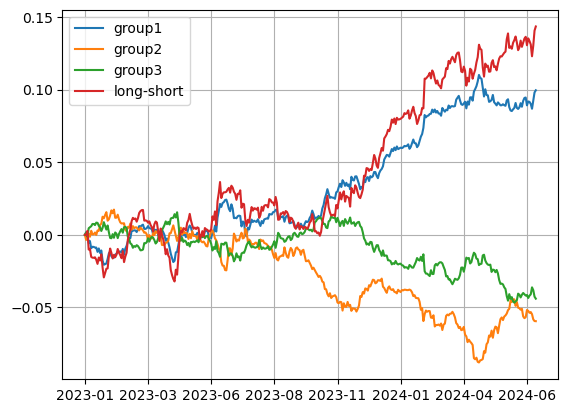

In [140]:
# 样本内
ret5_test = factor.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2024-06-30')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
# plot_return(factor_dp, 3)
plt.grid(True)

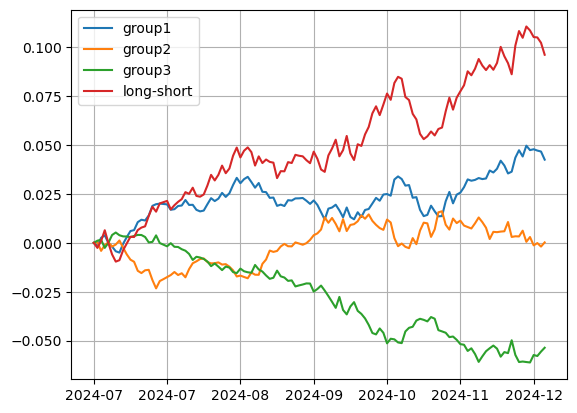

In [141]:
# 样本外
ret5_test = factor.loc[pd.to_datetime('2024-07-01'):pd.to_datetime('2024-12-31')]
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
plot_return(factor_gp, 3)
# plot_return(factor_zp, 4)
# plot_return(factor_dp, 3)
plt.grid(True)

In [9]:
# 每日IC值（分池）,factor为dataframe格式
def cal_IC_pool(factor):
    factor_gp, factor_zp, factor_dp = cal_pool_factor(factor)
    gp = cal_IC(factor_gp)
    zp = cal_IC(factor_zp)
    dp = cal_IC(factor_dp)
    return pd.concat([gp,zp,dp], keys = ['高平池', '中平池', '低平池'], axis = 1)

In [10]:
# 每日分组收益（分池）,factor为dataframe格式
def cal_group_pool_cum(factor):
    factor_gp, factor_zp, factor_dp = cal_pool_factor(factor)
    gp = pd.DataFrame(cal_group_return(factor_gp, 3)).T.iloc[:,:3]
    zp = pd.DataFrame(cal_group_return(factor_zp, 4)).T.iloc[:,:4]
    dp = pd.DataFrame(cal_group_return(factor_dp, 3)).T.iloc[:,:3]
    return pd.concat([gp, zp, dp], keys = ['高平池', '中平池', '低平池'], axis = 1).dropna()

In [ ]:
# pd.read_parquet("Fund_FlagST.parquet", engine="pyarrow")['FACTORVALUE'].sum()

3535

In [137]:
def cal_factor(series):
    PRET = series[-1] / series[0] - 1
    ID = (-1 / 7) * np.sign(PRET)
    return ID

def assign_scores(row):
    # 1. 对当前行排序
    row = row.dropna()
    row = np.abs(row)
    row = row.sort_values()
    stocks = row.index
    
    # 2. 计算5组的分割值（需要4个分割点）
    length = len(row)
    boundaries = [row[int(length/5*4)], row[int(length/5*3)], row[int(length/5*2)], row[int(length/5)]]
    return pd.Series((np.digitize(row, boundaries) + 1), index = stocks) / 15

data_return = data_close / data_close.shift(1) - 1
Wi = data_return.dropna(how='all').apply(assign_scores, axis=1)



In [138]:
factor = (Wi * np.sign(data_return)).rolling(7).sum() * data_close.rolling(7).apply(cal_factor) 

In [ ]:
factor_analyse(factor) # 7

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.174732 -0.186603 -0.061082 -0.054225 -0.183400 -0.034567   
多头年化超额    0.072016  0.022732  0.017136  0.088045  0.033697 -0.041362   
多头超额胜率    0.544693  0.530726  0.533520  0.540323  0.524194  0.491935   
多空夏普比率    0.991059  0.954655  0.106435  2.251349  1.214061 -1.118039   
概率1       0.359882  0.309735  0.563422  0.723810  0.400000  0.161905   
概率2       0.545723  0.424779  0.368732  0.561905  0.276190  0.152381   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.046879 -0.174112 -0.019502  
多头年化超额    0.044133  0.027637 -0.001706  
多头超额胜率    0.517857  0.517857  0.607143  
多空夏普比率    0.730718  2.435530 -0.957344  
概率1       0.216216  0.378378  0.486486  
概率2       0.297297  0.243243  0.324324

In [139]:
factor_analyse(factor) #6

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.174732 -0.186603 -0.061082 -0.054225 -0.183400 -0.034567   
多头年化超额    0.072016  0.022732  0.017136  0.088045  0.033697 -0.041362   
多头超额胜率    0.544693  0.530726  0.533520  0.540323  0.524194  0.491935   
多空夏普比率    0.991059  0.954655  0.106435  2.251349  1.214061 -1.118039   
概率1       0.359882  0.309735  0.563422  0.723810  0.400000  0.161905   
概率2       0.545723  0.424779  0.368732  0.561905  0.276190  0.152381   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.046879 -0.174112 -0.019502  
多头年化超额    0.044133  0.027637 -0.001706  
多头超额胜率    0.517857  0.517857  0.607143  
多空夏普比率    0.730718  2.435530 -0.957344  
概率1       0.216216  0.378378  0.486486  
概率2       0.297297  0.243243  0.324324